# Polynomial Regression

In [31]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, LeaveOneOut
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

# Reuse the data preparation from the previous analysis
games = ['Breakout', 'Qbert', 'Hero', 'KungFuMaster', 'Pong', 'Seaquest', 'Alien', 'BankHeist', 'BattleZone', 'RoadRunner']
dt_scores = [309.14, 36.98, 30.37, 29.41, 71.58, 2.05, 12.42, 0.63, 9.49, 25.00]
dm_scores = [367.13, 26.93, 7.77, 5.29, 64.31, 2.77, 11.74, -0.09, 7.20, 28.49]
score_diff = np.array(dt_scores) - np.array(dm_scores)

num_actions = [4, 6, 18, 14, 6, 18, 18, 18, 18, 18]
avg_trajectory = [1299.62, 1060.84, 1192.23, 2642.71, 2096.52, 1413.12, 932.20, 1185.34, 2068.26, 1123.01]
avg_reward = [40.40, 131.87, 127.36, 117.24, 13.21, 61.45, 109.86, 58.85, 12.61, 129.36]
avg_steps = [45.20, 56.75, 54.94, 109.53, 112.64, 87.23, 22.49, 20.04, 267.60, 81.03]
image_entropy = [1.50, 1.89, 2.01, 2.66, 0.68, 2.24, 2.02, 1.88, 2.84, 1.77]
feature_count = [23.33, 84.64, 38.84, 52.63, 9.16, 16.18, 22.88, 188.87, 13.88, 24.61]

data = pd.DataFrame({
    'Game': games,
    'ScoreDiff': score_diff,
    'NumActions': num_actions,
    'AvgTrajectory': avg_trajectory,
    'AvgReward': avg_reward,
    'AvgSteps': avg_steps,
    'ImageEntropy': image_entropy,
    'FeatureCount': feature_count
})

X = data[['NumActions', 'AvgTrajectory', 'AvgReward', 'AvgSteps', 'ImageEntropy', 'FeatureCount']]
y = data['ScoreDiff']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Feature selection using Lasso
lasso = Lasso(alpha=0.1)
selector = SelectFromModel(lasso, prefit=False)
selector.fit(X_scaled, y)
X_selected = selector.transform(X_scaled)
selected_features = X.columns[selector.get_support()].tolist()

print("Selected features:", selected_features)

# Define models
models = {
    "Ridge Regression": Ridge(alpha=1.0),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42)
}

# Perform cross-validation
cv = LeaveOneOut()
results = {}

for name, model in models.items():
    mse_scores = cross_val_score(model, X_selected, y, cv=cv, scoring='neg_mean_squared_error')
    mse_scores = -mse_scores  # Convert to positive MSE
    # r2_scores = cross_val_score(model, X_selected, y, cv=cv, scoring='r2')
    
    results[name] = {
        "MSE": mse_scores.mean(),
        "MSE_std": mse_scores.std(),
        # "R2": r2_scores.mean(),
        # "R2_std": r2_scores.std()
    }

# Print results
for name, metrics in results.items():
    print(f"\n{name}:")
    print(f"  Mean MSE: {metrics['MSE']:.4f} (+/- {metrics['MSE_std']:.4f})")
    # print(f"  Mean R2: {metrics['R2']:.4f} (+/- {metrics['R2_std']:.4f})")

# Train the Random Forest model on the full dataset for feature importance
rf_model = RandomForestRegressor(n_estimators=1000, random_state=42)
rf_model.fit(X_selected, y)

# Get feature importances
importances = rf_model.feature_importances_
feature_imp = pd.DataFrame({'feature': selected_features, 'importance': importances})
feature_imp = feature_imp.sort_values('importance', ascending=False)

print("\nFeature Importances:")
print(feature_imp)

Selected features: ['NumActions', 'AvgTrajectory', 'AvgReward', 'AvgSteps', 'ImageEntropy', 'FeatureCount']

Ridge Regression:
  Mean MSE: 1423.6081 (+/- 1994.1910)

Random Forest:
  Mean MSE: 548.9326 (+/- 1073.3546)

Feature Importances:
         feature  importance
0     NumActions    0.491974
4   ImageEntropy    0.134753
5   FeatureCount    0.123448
2      AvgReward    0.109574
1  AvgTrajectory    0.095597
3       AvgSteps    0.044654


# Random Forest Regression with 5 features

Random Forest Regression Model for Performance Difference:
Mean squared error: 25.21
R2 score: nan


/home/keyan/miniconda3/envs/ssm2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)



Feature Importance:
                     feature  importance
0                Num_Actions    0.496832
3              Image_Entropy    0.192611
4              Feature_Count    0.130882
1      Avg_Trajectory_Length    0.110243
2  Avg_Steps_to_First_Reward    0.069432


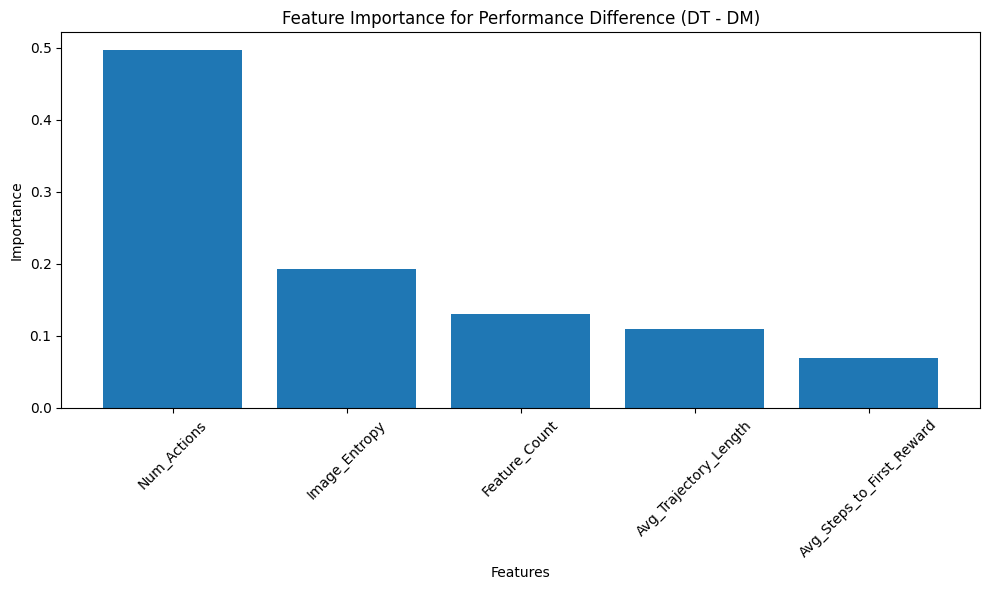

In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 1. Prepare the data
games = ['Breakout', 'Qbert', 'Hero', 'KungFuMaster', 'Pong', 'Seaquest', 'Alien', 'BankHeist', 'BattleZone', 'RoadRunner']
dt_scores = [309.14, 36.98, 30.37, 29.41, 71.58, 2.05, 12.42, 0.63, 9.49, 25.00]
dm_scores = [367.13, 26.93, 7.77, 5.29, 64.31, 2.77, 11.74, -0.09, 7.20, 28.49]
num_actions = [4, 6, 18, 14, 6, 18, 18, 18, 18, 18]
avg_trajectory_length = [1299.62, 1060.84, 1192.23, 2642.71, 2096.52, 1413.12, 932.20, 1185.34, 2068.26, 1123.01]
avg_steps_to_first_reward = [45.20, 56.75, 54.94, 109.53, 112.64, 87.23, 22.49, 20.04, 267.60, 81.03]
image_entropy = [1.50, 1.89, 2.01, 2.66, 0.68, 2.24, 2.02, 1.88, 2.84, 1.77]
feature_count = [23.33, 84.64, 38.84, 52.63, 9.16, 16.18, 22.88, 188.87, 13.88, 24.61]

data = pd.DataFrame({
    'Game': games,
    'DT_Score': dt_scores,
    'DM_Score': dm_scores,
    'Num_Actions': num_actions,
    'Avg_Trajectory_Length': avg_trajectory_length,
    'Avg_Steps_to_First_Reward': avg_steps_to_first_reward,
    'Image_Entropy': image_entropy,
    'Feature_Count': feature_count
})

# Calculate performance difference (DT - DM)
data['Performance_Difference'] = data['DT_Score'] - data['DM_Score']

# 2. Split the data into features (X) and target variable (y)
X = data[['Num_Actions', 'Avg_Trajectory_Length', 'Avg_Steps_to_First_Reward', 'Image_Entropy', 'Feature_Count']]
y = data['Performance_Difference']

# 3. Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# 4. Create and train the random forest regression model
rf = RandomForestRegressor(n_estimators=10000, random_state=42)
rf.fit(X_train, y_train)

# 5. Evaluate the model
y_pred = rf.predict(X_test)

print("Random Forest Regression Model for Performance Difference:")
print("Mean squared error: {:.2f}".format(mean_squared_error(y_test, y_pred)))
print("R2 score: {:.2f}".format(r2_score(y_test, y_pred)))

# 6. Analyze feature importance
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': rf.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# Visualize feature importance
plt.figure(figsize=(10, 6))
plt.bar(feature_importance['feature'], feature_importance['importance'])
plt.title('Feature Importance for Performance Difference (DT - DM)')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# # 7. Analyze the relationship between features and performance difference
# for feature in X.columns:
#     plt.figure(figsize=(10, 6))
#     plt.scatter(data[feature], data['Performance_Difference'])
#     plt.title(f'{feature} vs Performance Difference')
#     plt.xlabel(feature)
#     plt.ylabel('Performance Difference (DM - DT)')
#     plt.axhline(y=0, color='r', linestyle='--')
#     plt.tight_layout()
#     plt.show()

# Random Forest Regression with all features

Random Forest Regression Model for Performance Difference:
Mean squared error: 4.95
R2 score: 0.67

Feature Importance:
                     feature  importance
0                Num_Actions    0.443555
2           Avg_Total_Reward    0.136031
6          Compression_Ratio    0.113928
8              Feature_Count    0.102575
4              Image_Entropy    0.074793
1      Avg_Trajectory_Length    0.065262
3  Avg_Steps_to_First_Reward    0.044068
5                 Edge_Ratio    0.011609
7                       SSIM    0.008178


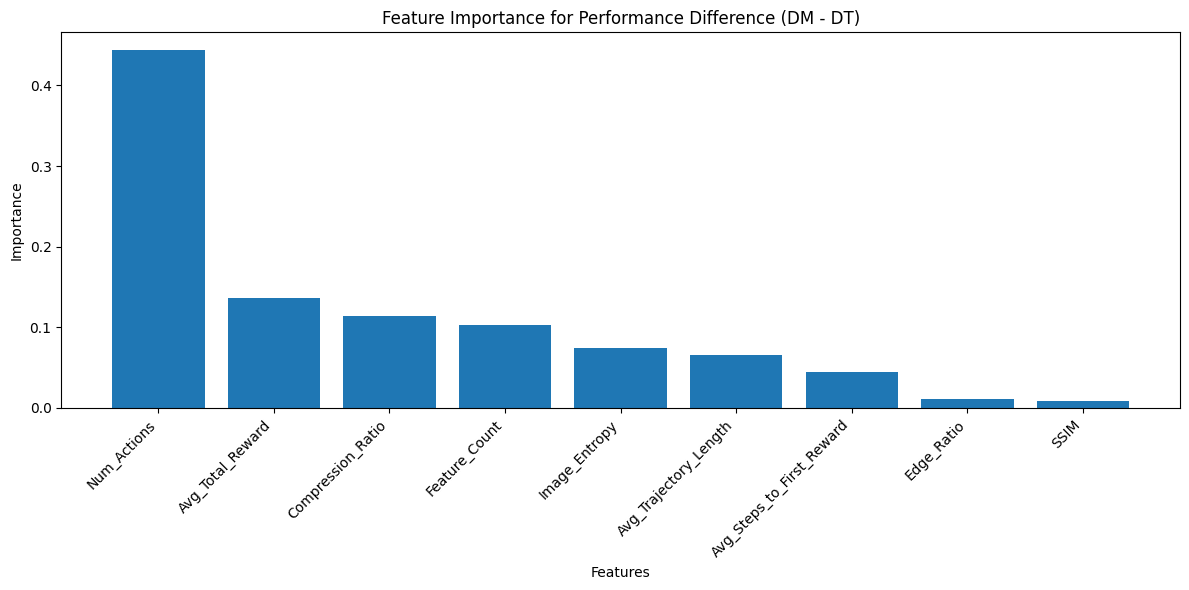


Games where Decision Mamba outperforms Decision Transformer:
         Game  Performance_Difference
0    Breakout                   57.99
5    Seaquest                    0.72
9  RoadRunner                    3.49

Games where Decision Transformer outperforms Decision Mamba:
           Game  Performance_Difference
1         Qbert                  -10.05
2          Hero                  -22.60
3  KungFuMaster                  -24.12
4          Pong                   -7.27
6         Alien                   -0.68
7     BankHeist                   -0.72
8    BattleZone                   -2.29


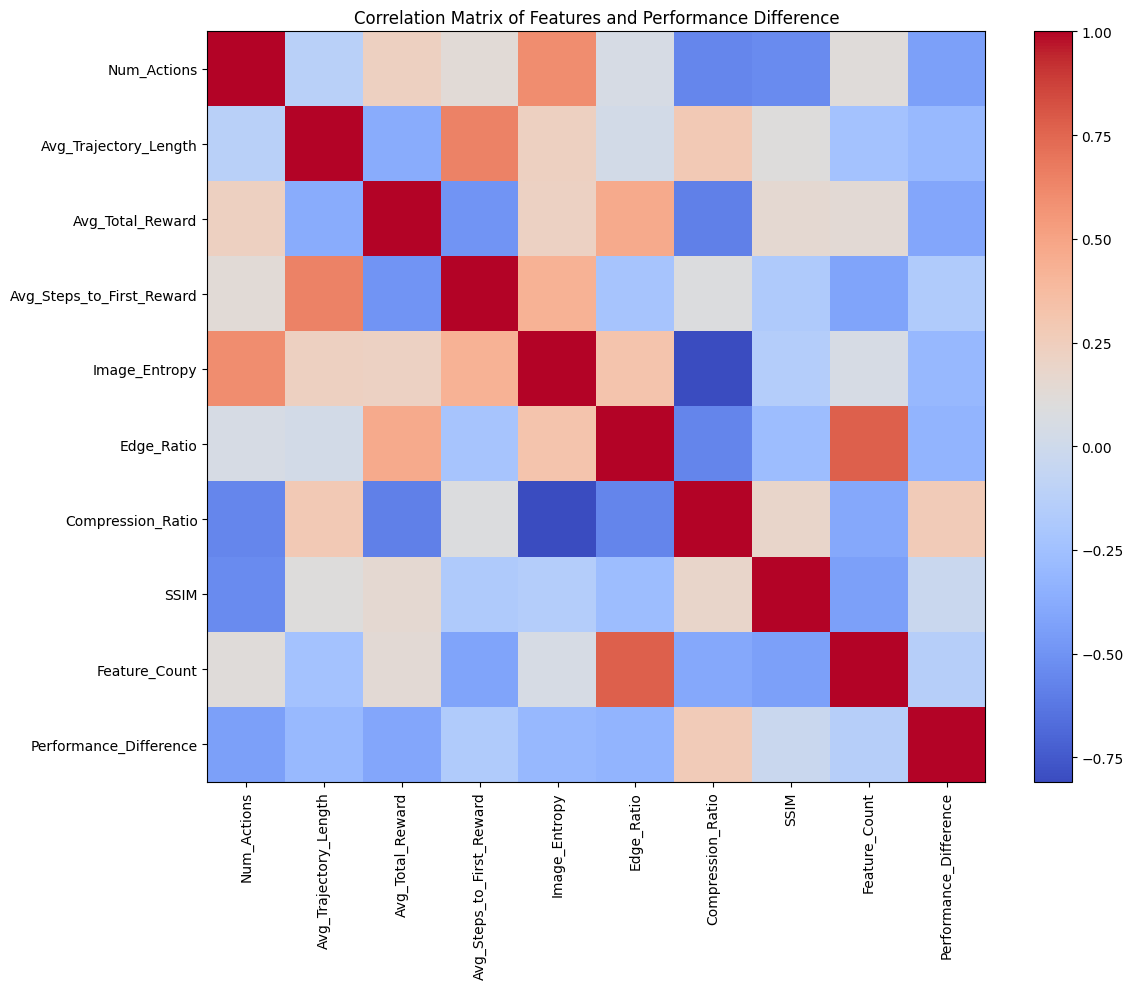

In [34]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 1. Prepare the data
games = ['Breakout', 'Qbert', 'Hero', 'KungFuMaster', 'Pong', 'Seaquest', 'Alien', 'BankHeist', 'BattleZone', 'RoadRunner']
dt_scores = [309.14, 36.98, 30.37, 29.41, 71.58, 2.05, 12.42, 0.63, 9.49, 25.00]
dm_scores = [367.13, 26.93, 7.77, 5.29, 64.31, 2.77, 11.74, -0.09, 7.20, 28.49]
num_actions = [4, 6, 18, 14, 6, 18, 18, 18, 18, 18]
avg_trajectory_length = [1299.62, 1060.84, 1192.23, 2642.71, 2096.52, 1413.12, 932.20, 1185.34, 2068.26, 1123.01]
avg_total_reward = [40.40, 131.87, 127.36, 117.24, 13.21, 61.45, 109.86, 58.85, 12.61, 129.36]
avg_steps_to_first_reward = [45.20, 56.75, 54.94, 109.53, 112.64, 87.23, 22.49, 20.04, 267.60, 81.03]
image_entropy = [1.50, 1.89, 2.01, 2.66, 0.68, 2.24, 2.02, 1.88, 2.84, 1.77]
edge_ratio = [0.08, 0.16, 0.11, 0.16, 0.05, 0.08, 0.05, 0.17, 0.08, 0.11]
compression_ratio = [21.35, 5.80, 10.55, 7.58, 40.00, 12.92, 7.71, 7.78, 9.31, 12.89]
ssim = [0.97, 0.99, 0.96, 0.97, 0.97, 0.96, 0.98, 0.87, 0.91, 0.88]
feature_count = [23.33, 84.64, 38.84, 52.63, 9.16, 16.18, 22.88, 188.87, 13.88, 24.61]

data = pd.DataFrame({
    'Game': games,
    'DT_Score': dt_scores,
    'DM_Score': dm_scores,
    'Num_Actions': num_actions,
    'Avg_Trajectory_Length': avg_trajectory_length,
    'Avg_Total_Reward': avg_total_reward,
    'Avg_Steps_to_First_Reward': avg_steps_to_first_reward,
    'Image_Entropy': image_entropy,
    'Edge_Ratio': edge_ratio,
    'Compression_Ratio': compression_ratio,
    'SSIM': ssim,
    'Feature_Count': feature_count
})

# Calculate performance difference (DM - DT)
data['Performance_Difference'] = data['DM_Score'] - data['DT_Score']

# 2. Split the data into features (X) and target variable (y)
X = data[['Num_Actions', 'Avg_Trajectory_Length', 'Avg_Total_Reward', 'Avg_Steps_to_First_Reward', 
          'Image_Entropy', 'Edge_Ratio', 'Compression_Ratio', 'SSIM', 'Feature_Count']]
y = data['Performance_Difference']

# 3. Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Create and train the random forest regression model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# 5. Evaluate the model
y_pred = rf.predict(X_test)

print("Random Forest Regression Model for Performance Difference:")
print("Mean squared error: {:.2f}".format(mean_squared_error(y_test, y_pred)))
print("R2 score: {:.2f}".format(r2_score(y_test, y_pred)))

# 6. Analyze feature importance
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': rf.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# Visualize feature importance
plt.figure(figsize=(12, 6))
plt.bar(feature_importance['feature'], feature_importance['importance'])
plt.title('Feature Importance for Performance Difference (DM - DT)')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# # 7. Analyze the relationship between features and performance difference
# for feature in X.columns:
#     plt.figure(figsize=(10, 6))
#     plt.scatter(data[feature], data['Performance_Difference'])
#     plt.title(f'{feature} vs Performance Difference')
#     plt.xlabel(feature)
#     plt.ylabel('Performance Difference (DM - DT)')
#     plt.axhline(y=0, color='r', linestyle='--')
#     plt.tight_layout()
#     plt.show()

# 8. Print games where DM outperforms DT and vice versa
print("\nGames where Decision Mamba outperforms Decision Transformer:")
print(data[data['Performance_Difference'] > 0][['Game', 'Performance_Difference']])

print("\nGames where Decision Transformer outperforms Decision Mamba:")
print(data[data['Performance_Difference'] < 0][['Game', 'Performance_Difference']])

# 9. Correlation analysis
correlation_matrix = data.drop(['Game', 'DT_Score', 'DM_Score'], axis=1).corr()
plt.figure(figsize=(12, 10))
plt.imshow(correlation_matrix, cmap='coolwarm', aspect='auto')
plt.colorbar()
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.title('Correlation Matrix of Features and Performance Difference')
plt.tight_layout()
plt.show()

### Basically fit my expectation. remove metrics 'avg_total_reward', 'SSIM', 'edge_ratio'

Random Forest Regression Model for Performance Difference (DT - DM):
Mean squared error: 43.95
R2 score: nan

Feature Importance:
                     feature  importance
0                Num_Actions    0.464888
3              Image_Entropy    0.141330
4          Compression_Ratio    0.126808
5              Feature_Count    0.109012
1      Avg_Trajectory_Length    0.097646
2  Avg_Steps_to_First_Reward    0.060316


/home/keyan/miniconda3/envs/ssm2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


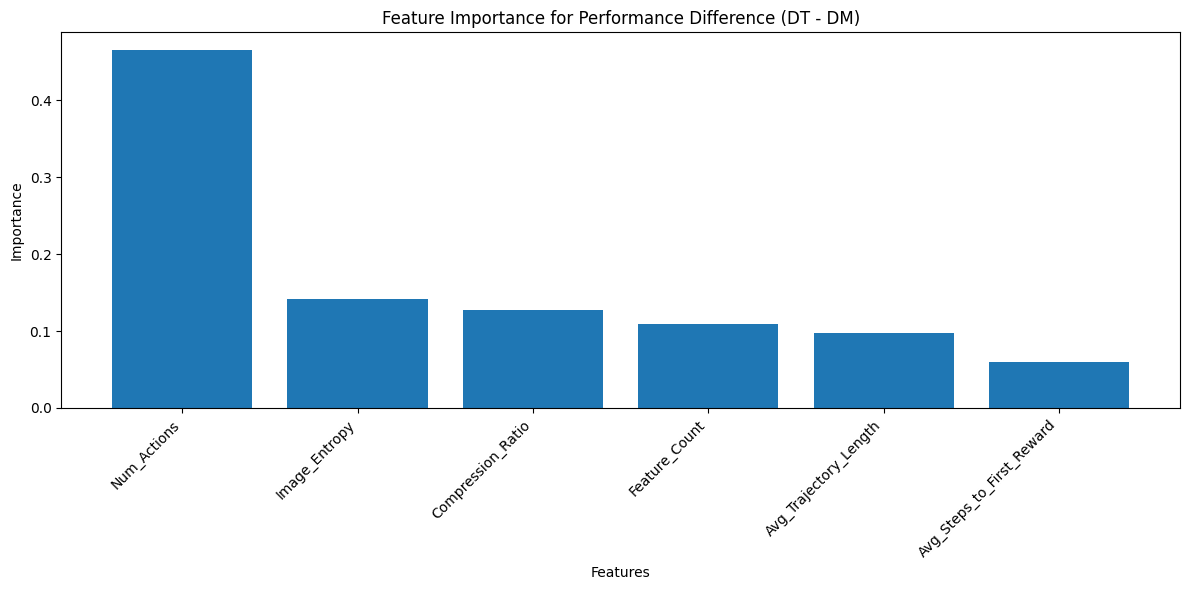


Games where Decision Transformer outperforms Decision Mamba:
           Game  Performance_Difference
1         Qbert                   10.05
2          Hero                   22.60
3  KungFuMaster                   24.12
4          Pong                    7.27
6         Alien                    0.68
7     BankHeist                    0.72
8    BattleZone                    2.29

Games where Decision Mamba outperforms Decision Transformer:
         Game  Performance_Difference
0    Breakout                  -57.99
5    Seaquest                   -0.72
9  RoadRunner                   -3.49


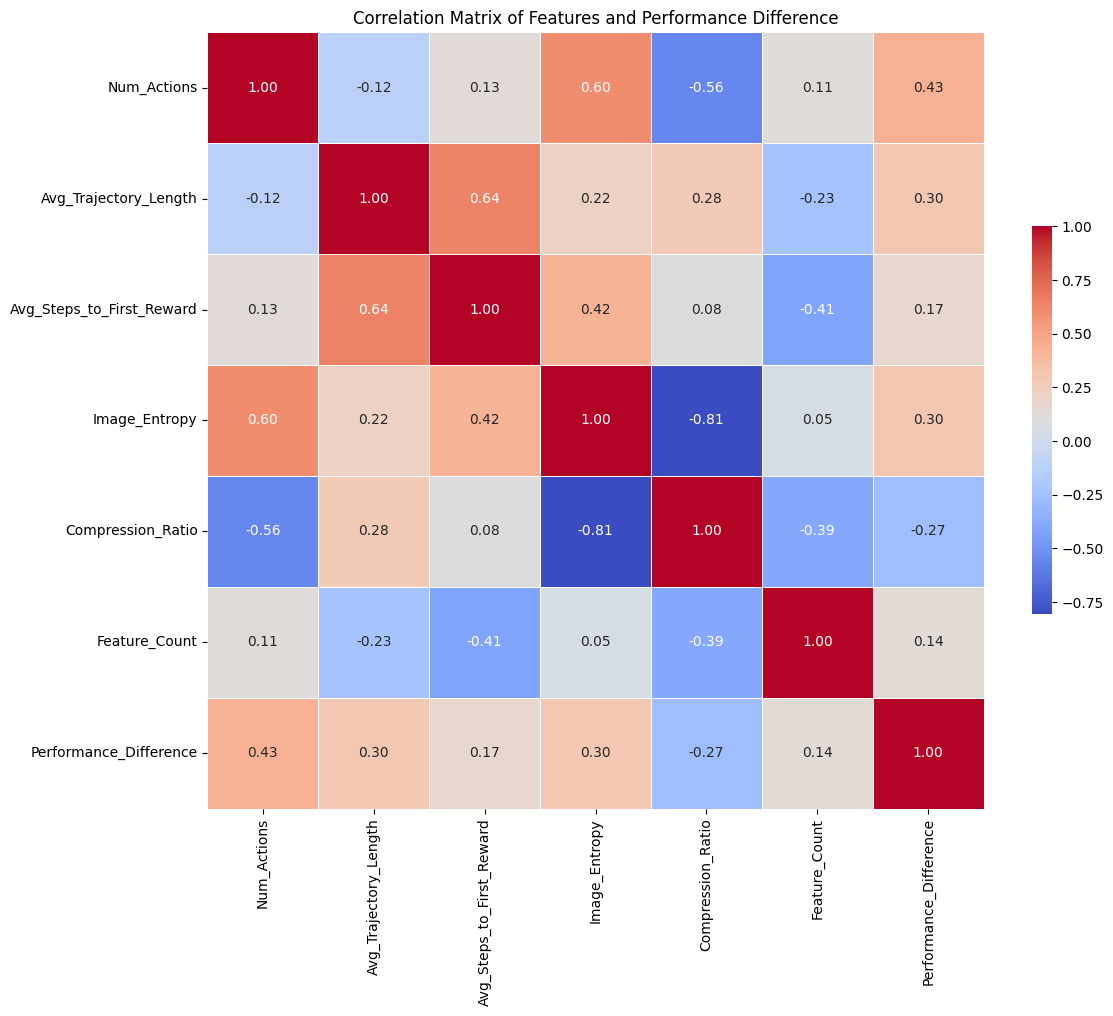

In [42]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns


# 1. Prepare the data
games = ['Breakout', 'Qbert', 'Hero', 'KungFuMaster', 'Pong', 'Seaquest', 'Alien', 'BankHeist', 'BattleZone', 'RoadRunner']
dt_scores = [309.14, 36.98, 30.37, 29.41, 71.58, 2.05, 12.42, 0.63, 9.49, 25.00]
dm_scores = [367.13, 26.93, 7.77, 5.29, 64.31, 2.77, 11.74, -0.09, 7.20, 28.49]
num_actions = [4, 6, 18, 14, 6, 18, 18, 18, 18, 18]
avg_trajectory_length = [1299.62, 1060.84, 1192.23, 2642.71, 2096.52, 1413.12, 932.20, 1185.34, 2068.26, 1123.01]
avg_steps_to_first_reward = [45.20, 56.75, 54.94, 109.53, 112.64, 87.23, 22.49, 20.04, 267.60, 81.03]
image_entropy = [1.50, 1.89, 2.01, 2.66, 0.68, 2.24, 2.02, 1.88, 2.84, 1.77]
compression_ratio = [21.35, 5.80, 10.55, 7.58, 40.00, 12.92, 7.71, 7.78, 9.31, 12.89]
feature_count = [23.33, 84.64, 38.84, 52.63, 9.16, 16.18, 22.88, 188.87, 13.88, 24.61]

data = pd.DataFrame({
    'Game': games,
    'DT_Score': dt_scores,
    'DM_Score': dm_scores,
    'Num_Actions': num_actions,
    'Avg_Trajectory_Length': avg_trajectory_length,
    'Avg_Steps_to_First_Reward': avg_steps_to_first_reward,
    'Image_Entropy': image_entropy,
    'Compression_Ratio': compression_ratio,
    'Feature_Count': feature_count
})

# Calculate performance difference (DT - DM)
data['Performance_Difference'] = data['DT_Score'] - data['DM_Score']

# 2. Split the data into features (X) and target variable (y)
X = data[['Num_Actions', 'Avg_Trajectory_Length', 'Avg_Steps_to_First_Reward', 
          'Image_Entropy', 'Compression_Ratio', 'Feature_Count']]
y = data['Performance_Difference']

# 3. Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# 4. Create and train the random forest regression model
rf = RandomForestRegressor(n_estimators=1000, random_state=42)
rf.fit(X_train, y_train)

# 5. Evaluate the model
y_pred = rf.predict(X_test)

print("Random Forest Regression Model for Performance Difference (DT - DM):")
print("Mean squared error: {:.2f}".format(mean_squared_error(y_test, y_pred)))
print("R2 score: {:.2f}".format(r2_score(y_test, y_pred)))

# 6. Analyze feature importance
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': rf.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# Visualize feature importance
plt.figure(figsize=(12, 6))
plt.bar(feature_importance['feature'], feature_importance['importance'])
plt.title('Feature Importance for Performance Difference (DT - DM)')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# # 7. Analyze the relationship between features and performance difference
# for feature in X.columns:
#     plt.figure(figsize=(10, 6))
#     plt.scatter(data[feature], data['Performance_Difference'])
#     plt.title(f'{feature} vs Performance Difference')
#     plt.xlabel(feature)
#     plt.ylabel('Performance Difference (DT - DM)')
#     plt.axhline(y=0, color='r', linestyle='--')
#     plt.tight_layout()
#     plt.show()

# 8. Print games where DT outperforms DM and vice versa
print("\nGames where Decision Transformer outperforms Decision Mamba:")
print(data[data['Performance_Difference'] > 0][['Game', 'Performance_Difference']])

print("\nGames where Decision Mamba outperforms Decision Transformer:")
print(data[data['Performance_Difference'] < 0][['Game', 'Performance_Difference']])


# 9. Correlation analysis
correlation_matrix = data.drop(['Game', 'DT_Score', 'DM_Score'], axis=1).corr()
# Set up the matplotlib figure
plt.figure(figsize=(12, 10))
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', 
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation Matrix of Features and Performance Difference')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


### 14 games, remove metrics 'avg_total_reward', 'SSIM', 'edge_ratio'

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 1. Prepare the data
games = ['Breakout', 'Qbert', 'Hero', 'KungFuMaster', 'Pong', 'Seaquest', 'Alien', 'BankHeist', 'BattleZone', 'RoadRunner', 'FishingDerby', 'MsPacman', 'SpaceInvaders', 'Zaxxon']
dt_scores = [309.14, 36.98, 30.37, 29.41, 71.58, 2.05, 12.42, 0.63, 9.49, 25.00, 160.44, 18.20, 26.06, 24.99]
dm_scores = [367.13, 26.93, 7.77, 5.29, 64.31, 2.77, 11.74, -0.09, 7.20, 28.49, 153.14, 23.42, 28.77, 19.74]
num_actions = [4, 6, 18, 14, 6, 18, 18, 18, 18, 18, 18, 9, 6, 18]
avg_trajectory_length = [1299.62, 1060.84, 1192.23, 2642.71, 2096.52, 1413.12, 932.20, 1185.34, 2068.26, 1123.01, 1775.02, 1169.08, 1820.79, 1566.38]
avg_steps_to_first_reward = [45.20, 56.75, 54.94, 109.53, 112.64, 87.23, 22.49, 20.04, 267.60, 81.03, 44.58, 71.05, 52.07, 338.68]
image_entropy = [1.50, 1.89, 2.01, 2.66, 0.68, 2.24, 2.02, 1.88, 2.84, 1.77, 2.20, 2.06, 0.84, 1.16]
compression_ratio = [21.35, 5.80, 10.55, 7.58, 40.00, 12.92, 7.71, 7.78, 9.31, 12.89, 8.01, 7.95, 13.30, 17.59]
feature_count = [23.33, 84.64, 38.84, 52.63, 9.16, 16.18, 22.88, 188.87, 13.88, 24.61, 23.34, 164.83, 65.85, 26.59]

data = pd.DataFrame({
    'Game': games,
    'DT_Score': dt_scores,
    'DM_Score': dm_scores,
    'Num_Actions': num_actions,
    'Avg_Trajectory_Length': avg_trajectory_length,
    'Avg_Steps_to_First_Reward': avg_steps_to_first_reward,
    'Image_Entropy': image_entropy,
    'Compression_Ratio': compression_ratio,
    'Feature_Count': feature_count
})

# Calculate performance difference (DT - DM)
data['Performance_Difference'] = data['DT_Score'] - data['DM_Score']

# 2. Split the data into features (X) and target variable (y)
X = data[['Num_Actions', 'Avg_Trajectory_Length', 'Avg_Steps_to_First_Reward', 
          'Image_Entropy', 'Compression_Ratio', 'Feature_Count']]
y = data['Performance_Difference']

# 3. Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=888)

# 4. Create and train the random forest regression model
rf = RandomForestRegressor(n_estimators=1000, random_state=888)
rf.fit(X_train, y_train)

# 5. Evaluate the model
y_pred = rf.predict(X_test)

print("Random Forest Regression Model for Performance Difference (DT - DM):")
print("Mean squared error: {:.2f}".format(mean_squared_error(y_test, y_pred)))
print("R2 score: {:.2f}".format(r2_score(y_test, y_pred)))

# 6. Analyze feature importance
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': rf.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# # Visualize feature importance
# plt.figure(figsize=(12, 6))
# plt.bar(feature_importance['feature'], feature_importance['importance'])
# plt.title('Feature Importance for Performance Difference (DT - DM)')
# plt.xlabel('Features')
# plt.ylabel('Importance')
# plt.xticks(rotation=45, ha='right')
# plt.tight_layout()
# plt.show()

# # 7. Analyze the relationship between features and performance difference
# for feature in X.columns:
#     plt.figure(figsize=(10, 6))
#     plt.scatter(data[feature], data['Performance_Difference'])
#     for i, game in enumerate(data['Game']):
#         plt.annotate(game, (data[feature][i], data['Performance_Difference'][i]))
#     plt.title(f'{feature} vs Performance Difference')
#     plt.xlabel(feature)
#     plt.ylabel('Performance Difference (DT - DM)')
#     plt.axhline(y=0, color='r', linestyle='--')
#     plt.tight_layout()
#     plt.show()

# # 8. Print games where DT outperforms DM and vice versa
# print("\nGames where Decision Transformer outperforms Decision Mamba:")
# print(data[data['Performance_Difference'] > 0][['Game', 'Performance_Difference']])

# print("\nGames where Decision Mamba outperforms Decision Transformer:")
# print(data[data['Performance_Difference'] < 0][['Game', 'Performance_Difference']])

# # 9. Correlation analysis
# correlation_matrix = data.drop(['Game', 'DT_Score', 'DM_Score'], axis=1).corr()
# plt.figure(figsize=(12, 10))
# plt.imshow(correlation_matrix, cmap='coolwarm', aspect='auto')
# plt.colorbar()
# plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90)
# plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
# plt.title('Correlation Matrix of Features and Performance Difference')
# plt.tight_layout()
# plt.show()

Random Forest Regression Model for Performance Difference (DT - DM):
Mean squared error: 273.17
R2 score: -0.41

Feature Importance:
                     feature  importance
0                Num_Actions    0.478332
4          Compression_Ratio    0.224065
1      Avg_Trajectory_Length    0.182434
3              Image_Entropy    0.051264
2  Avg_Steps_to_First_Reward    0.032027
5              Feature_Count    0.031878


## DT/DM as metric, cross-validation

Model 1: (DT - DM) / max(DT, DM)
Mean squared error: -0.1040 (+/- 0.1358)
R2 score: -3.07 (+/- 8.70)

Model 2: DT / DM
Mean squared error: -2.8310 (+/- 3.4778)
R2 score: -61.99 (+/- 105.48)

Feature Importance for Model 1:
                     feature  importance
5              Feature_Count    0.291985
1      Avg_Trajectory_Length    0.195049
4          Compression_Ratio    0.164534
3              Image_Entropy    0.155947
2  Avg_Steps_to_First_Reward    0.151962
0                Num_Actions    0.040523

Feature Importance for Model 2:
                     feature  importance
5              Feature_Count    0.282017
1      Avg_Trajectory_Length    0.275924
4          Compression_Ratio    0.149699
3              Image_Entropy    0.137820
2  Avg_Steps_to_First_Reward    0.120109
0                Num_Actions    0.034430

Games performance comparison (sorted by Norm_Diff_1):
            Game  DT_Score  DM_Score  Norm_Diff_1  Norm_Diff_2
3   KungFuMaster     29.41      5.29     0.820129   

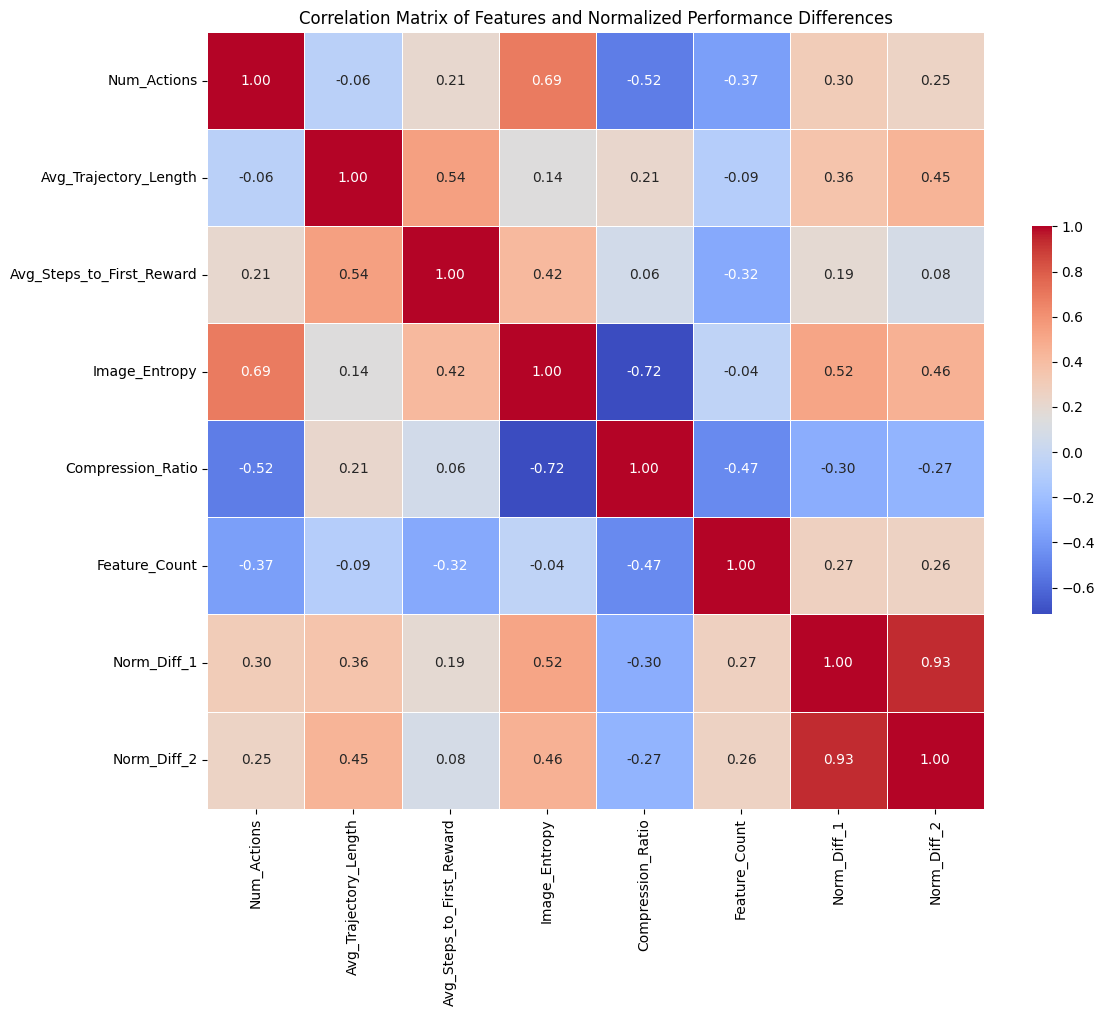

In [28]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate, KFold
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Prepare the data (BankHeist and Seaquest removed)
games = ['Breakout', 'Qbert', 'Hero', 'KungFuMaster', 'Pong', 'Alien', 'BattleZone', 'RoadRunner', 'FishingDerby', 'SpaceInvaders']
dt_scores = [309.14, 36.98, 30.37, 29.41, 71.58, 12.42, 9.49, 25.00, 160.44, 26.06]
dm_scores = [367.13, 26.93, 7.77, 5.29, 64.31, 11.74, 7.20, 28.49, 153.14, 28.77]
num_actions = [4, 6, 18, 14, 6, 18, 18, 18, 18, 6]
avg_trajectory_length = [1299.62, 1060.84, 1192.23, 2642.71, 2096.52, 932.20, 2068.26, 1123.01, 1775.02, 1820.79]
avg_steps_to_first_reward = [45.20, 56.75, 54.94, 109.53, 112.64, 22.49, 267.60, 81.03, 44.58, 52.07]
image_entropy = [1.50, 1.89, 2.01, 2.66, 0.68, 2.02, 2.84, 1.77, 2.20, 0.84]
compression_ratio = [21.35, 5.80, 10.55, 7.58, 40.00, 7.71, 9.31, 12.89, 8.01, 13.30]
feature_count = [23.33, 84.64, 38.84, 52.63, 9.16, 22.88, 13.88, 24.61, 23.34, 65.85]

data = pd.DataFrame({
    'Game': games,
    'DT_Score': dt_scores,
    'DM_Score': dm_scores,
    'Num_Actions': num_actions,
    'Avg_Trajectory_Length': avg_trajectory_length,
    'Avg_Steps_to_First_Reward': avg_steps_to_first_reward,
    'Image_Entropy': image_entropy,
    'Compression_Ratio': compression_ratio,
    'Feature_Count': feature_count
})

# Calculate normalized performance differences
data['Norm_Diff_1'] = (data['DT_Score'] - data['DM_Score']) / np.maximum(data['DT_Score'], data['DM_Score'])
data['Norm_Diff_2'] = data['DT_Score'] / data['DM_Score']

# 2. Prepare features (X) and target variables (y1, y2)
X = data[['Num_Actions', 'Avg_Trajectory_Length', 'Avg_Steps_to_First_Reward', 
          'Image_Entropy', 'Compression_Ratio', 'Feature_Count']]
y1 = data['Norm_Diff_1']
y2 = data['Norm_Diff_2']

# 3. Set up cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# 4. Create and train the random forest regression models with cross-validation
rf1 = RandomForestRegressor(n_estimators=1000, random_state=42)
rf2 = RandomForestRegressor(n_estimators=1000, random_state=42)

scoring = {'mse': make_scorer(mean_squared_error), 'r2': make_scorer(r2_score)}
cv_results1 = cross_validate(rf1, X, y1, cv=cv, scoring=scoring, return_estimator=True)
cv_results2 = cross_validate(rf2, X, y2, cv=cv, scoring=scoring, return_estimator=True)

# 5. Evaluate the models
print("Model 1: (DT - DM) / max(DT, DM)")
print("Mean squared error: {:.4f} (+/- {:.4f})".format(-cv_results1['test_mse'].mean(), cv_results1['test_mse'].std() * 2))
print("R2 score: {:.2f} (+/- {:.2f})".format(cv_results1['test_r2'].mean(), cv_results1['test_r2'].std() * 2))

print("\nModel 2: DT / DM")
print("Mean squared error: {:.4f} (+/- {:.4f})".format(-cv_results2['test_mse'].mean(), cv_results2['test_mse'].std() * 2))
print("R2 score: {:.2f} (+/- {:.2f})".format(cv_results2['test_r2'].mean(), cv_results2['test_r2'].std() * 2))

# 6. Analyze and compare feature importances
def get_feature_importance(cv_results):
    return pd.DataFrame({'feature': X.columns, 
                         'importance': np.mean([est.feature_importances_ for est in cv_results['estimator']], axis=0)})

feature_importance1 = get_feature_importance(cv_results1).sort_values('importance', ascending=False)
feature_importance2 = get_feature_importance(cv_results2).sort_values('importance', ascending=False)

print("\nFeature Importance for Model 1:")
print(feature_importance1)
print("\nFeature Importance for Model 2:")
print(feature_importance2)

# 7. Print games performance comparison, sorted by both normalized differences
print("\nGames performance comparison (sorted by Norm_Diff_1):")
comparison = data[['Game', 'DT_Score', 'DM_Score', 'Norm_Diff_1', 'Norm_Diff_2']].sort_values('Norm_Diff_1', ascending=False)
print(comparison)

# 8. Correlation analysis
correlation_matrix = data.drop(['Game', 'DT_Score', 'DM_Score'], axis=1).corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', 
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation Matrix of Features and Normalized Performance Differences')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Regresion Analysis with random forest
### 12 games, remove metrics 'avg_total_reward', 'SSIM', 'edge_ratio', cross-validation 6 fold, 

Cross-Validation Results:
RMSE scores: [ 9.66552018 42.32650089 14.94770403  3.75726751 21.97303176 12.76765171]
Mean RMSE: 17.57 (+/- 24.70)

Feature Importance:
                          feature  importance
0                     Num_Actions    0.443543
4               Compression_Ratio    0.213261
1               Trajectory_Length    0.103108
5                   Feature_Count    0.093484
3                   Image_Entropy    0.092782
2  Steps_to_First_non-zero_Reward    0.053821


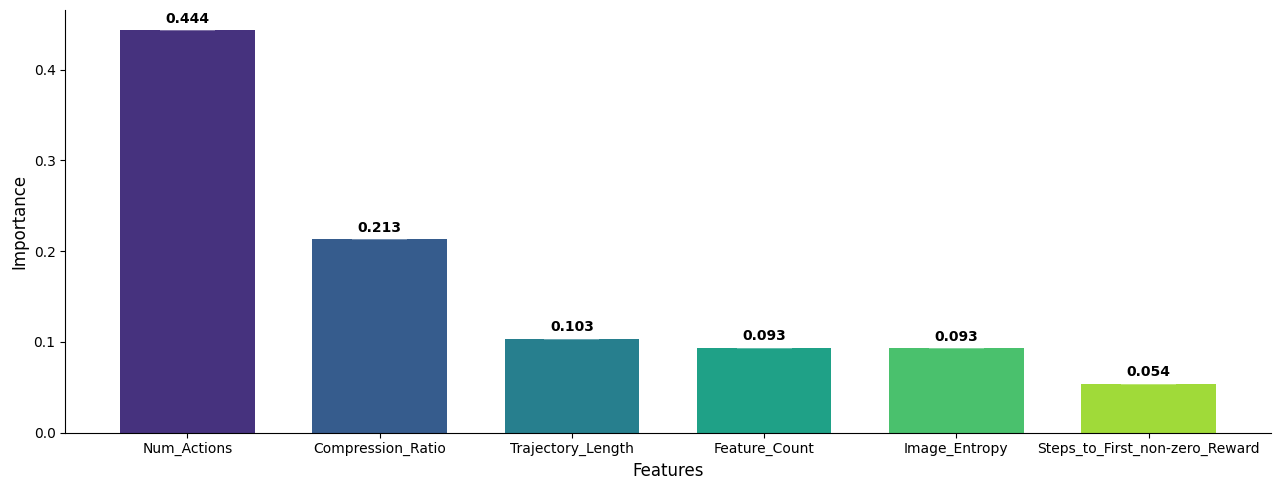

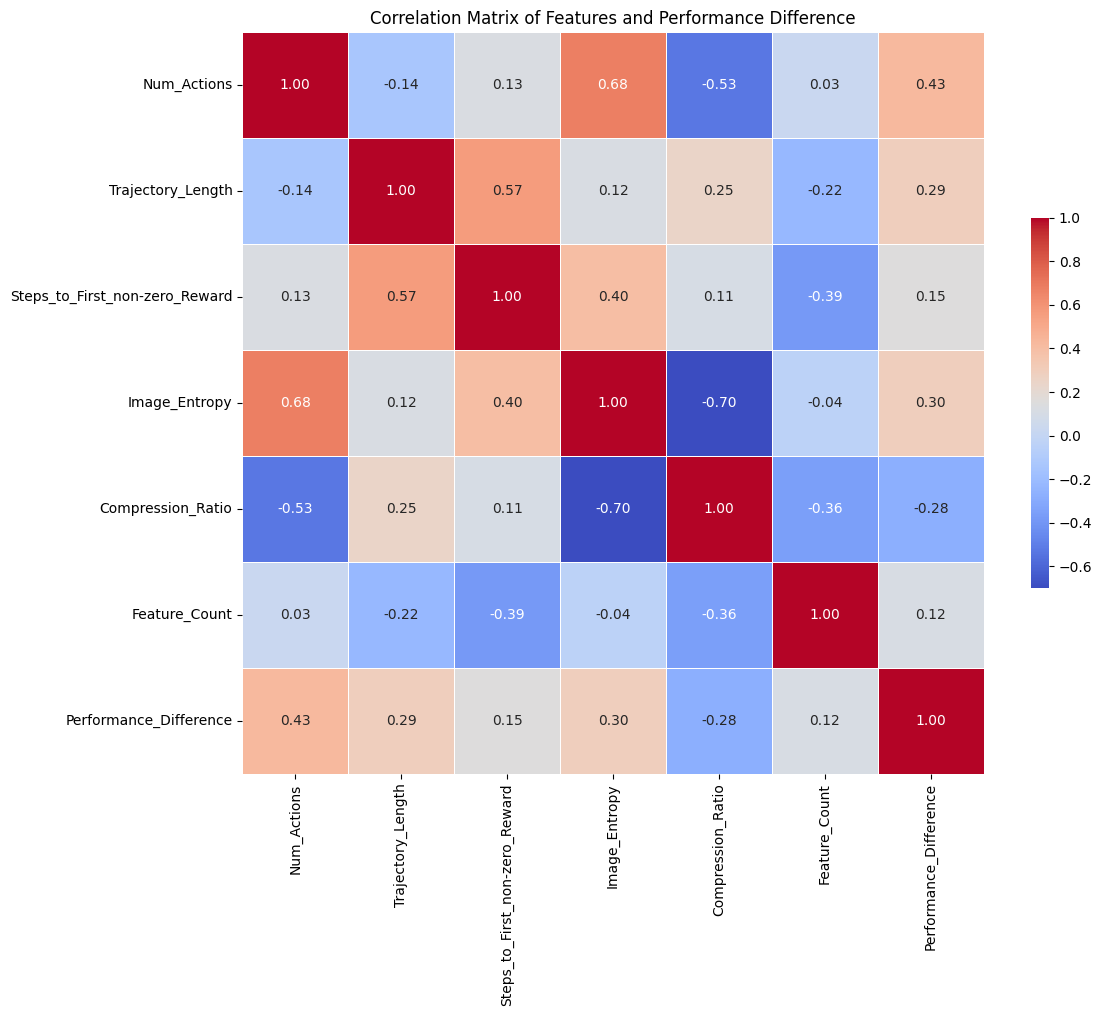

In [56]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Prepare the data
games = ['Breakout', 'Qbert', 'Hero', 'KungFuMaster', 'Pong', 'Seaquest', 'Alien', 'BankHeist', 'BattleZone', 'RoadRunner', 'SpaceInvaders', 'FishingDerby']
dt_scores = [309.14, 36.98, 30.37, 29.41, 71.58, 2.05, 12.42, 0.63, 9.49, 25.00, 26.06, 160.44]
dm_scores = [367.13, 26.93, 7.77, 5.29, 64.31, 2.77, 11.74, -0.09, 7.20, 28.49, 28.77, 153.14]
num_actions = [4, 6, 18, 14, 6, 18, 18, 18, 18, 18, 6, 18]
avg_trajectory_length = [1299.62, 1060.84, 1192.23, 2642.71, 2096.52, 1413.12, 932.20, 1185.34, 2068.26, 1123.01, 1820.79, 1775.02]
avg_steps_to_first_non_zero_reward = [45.20, 56.75, 54.94, 109.53, 112.64, 87.23, 22.49, 20.04, 267.60, 81.03, 52.07, 44.58]
image_entropy = [1.50, 1.89, 2.01, 2.66, 0.68, 2.24, 2.02, 1.88, 2.84, 1.77, 0.84, 2.20]
compression_ratio = [21.35, 5.80, 10.55, 7.58, 40.00, 12.92, 7.71, 7.78, 9.31, 12.89, 13.30, 8.01]
feature_count = [23.33, 84.64, 38.84, 52.63, 9.16, 16.18, 22.88, 188.87, 13.88, 24.61, 65.85, 23.34]

data = pd.DataFrame({
    'Game': games,
    'DT_Score': dt_scores,
    'DM_Score': dm_scores,
    'Num_Actions': num_actions,
    'Trajectory_Length': avg_trajectory_length,
    'Steps_to_First_non-zero_Reward': avg_steps_to_first_non_zero_reward,
    'Image_Entropy': image_entropy,
    'Compression_Ratio': compression_ratio,
    'Feature_Count': feature_count
})

# Calculate performance difference (DT - DM)
data['Performance_Difference'] = data['DT_Score'] - data['DM_Score'] 

# 2. Prepare features (X) and target variable (y)
X = data[['Num_Actions', 'Trajectory_Length', 'Steps_to_First_non-zero_Reward', 
          'Image_Entropy', 'Compression_Ratio', 'Feature_Count']]
y = data['Performance_Difference']

# 3. Create the Random Forest Regression model
rf = RandomForestRegressor(n_estimators=1000, random_state=42)

# 4. Perform cross-validation
cv = KFold(n_splits=6, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf, X, y, cv=cv, scoring='neg_mean_squared_error')

# Convert MSE to RMSE and make positive
rmse_scores = np.sqrt(-cv_scores)

print("Cross-Validation Results:")
print("RMSE scores:", rmse_scores)
print("Mean RMSE: {:.2f} (+/- {:.2f})".format(rmse_scores.mean(), rmse_scores.std() * 2))

# 5. Fit the model on the entire dataset for feature importance
rf.fit(X, y)

# 6. Analyze feature importance
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': rf.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# Visualize feature importance
# Sort feature importance in descending order
feature_importance_sorted = feature_importance.sort_values('importance', ascending=False)
colors = sns.color_palette("viridis", n_colors=len(feature_importance_sorted))  # Create a color palette

plt.figure(figsize=(13, 5))
bars = plt.bar(feature_importance_sorted['feature'], feature_importance_sorted['importance'], 
               color=colors, edgecolor='none', width=0.7)  # Increased width from default 0.8 to 0.9
plt.xlabel('Features', fontsize=12)
plt.ylabel('Importance', fontsize=12)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Add value labels
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height()+0.005, 
             f'{bar.get_height():.3f}', 
             ha='center', va='bottom', fontsize=10, fontweight='bold', 
             bbox=dict(facecolor='white', edgecolor='none', alpha=0.3))

plt.tight_layout()
plt.show()


# 7. Correlation analysis
correlation_matrix = data.drop(['Game', 'DT_Score', 'DM_Score'], axis=1).corr()
# Set up the matplotlib figure
plt.figure(figsize=(12, 10))
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', 
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation Matrix of Features and Performance Difference')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()